In [1]:
!pip install ds-box

     |████████████████████████████████| 153kB 2.8MB/s 


In [0]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = (12.0, 5.0)

import seaborn as sns
sns.set(style='white')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Outliers detection
Notebook and DSbox lib packaged by [V. Levorato](https://www.linkedin.com/in/vlevorato/).<br/>
GitHub: https://github.com/vlevorato/dsbox

## Univariate data: application to  time series
Examples of application for using median and FFT filtering on a small dataset.

### Data import
The data used for this tutorial are taken from the Numenta Anomaly Benchmark (NAB).</br> GitHub: https://github.com/numenta/NAB

**real Ad Exchange**

Online advertisement clicking rates, where the metrics are cost-per-click (CPC) and cost per thousand impressions (CPM).

*Ahmad, S., Lavin, A., Purdy, S., & Agha, Z. (2017). Unsupervised real-time anomaly detection for streaming data. Neurocomputing, Available online 2 June 2017, ISSN 0925-2312, https://doi.org/10.1016/j.neucom.2017.04.070*

In [0]:
df = pd.read_csv('https://github.com/numenta/NAB/raw/master/data/realAdExchange/exchange-3_cpc_results.csv')

In [0]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')

In [103]:
df.head(3)

,value
timestamp,
2011-07-01 00:15:01,0.102709
2011-07-01 01:15:01,0.068039
2011-07-01 02:15:01,0.077994


In [0]:
# taken from https://github.com/numenta/NAB/blob/master/labels/combined_labels.json
anomalies_dates= ["2011-07-14 10:15:01",
        "2011-07-20 10:15:01",
        "2011-08-13 10:15:01"]

In [0]:
for i in range(0, len(anomalies_dates)):
  anomalies_dates[i] = pd.to_datetime(anomalies_dates[i])

In [0]:
df['anomaly'] = df.index.map(lambda x: 1 if x in anomalies_dates else 0)
df['anomaly_viz'] = df.index.map(lambda x: 1 if x in anomalies_dates else np.nan)

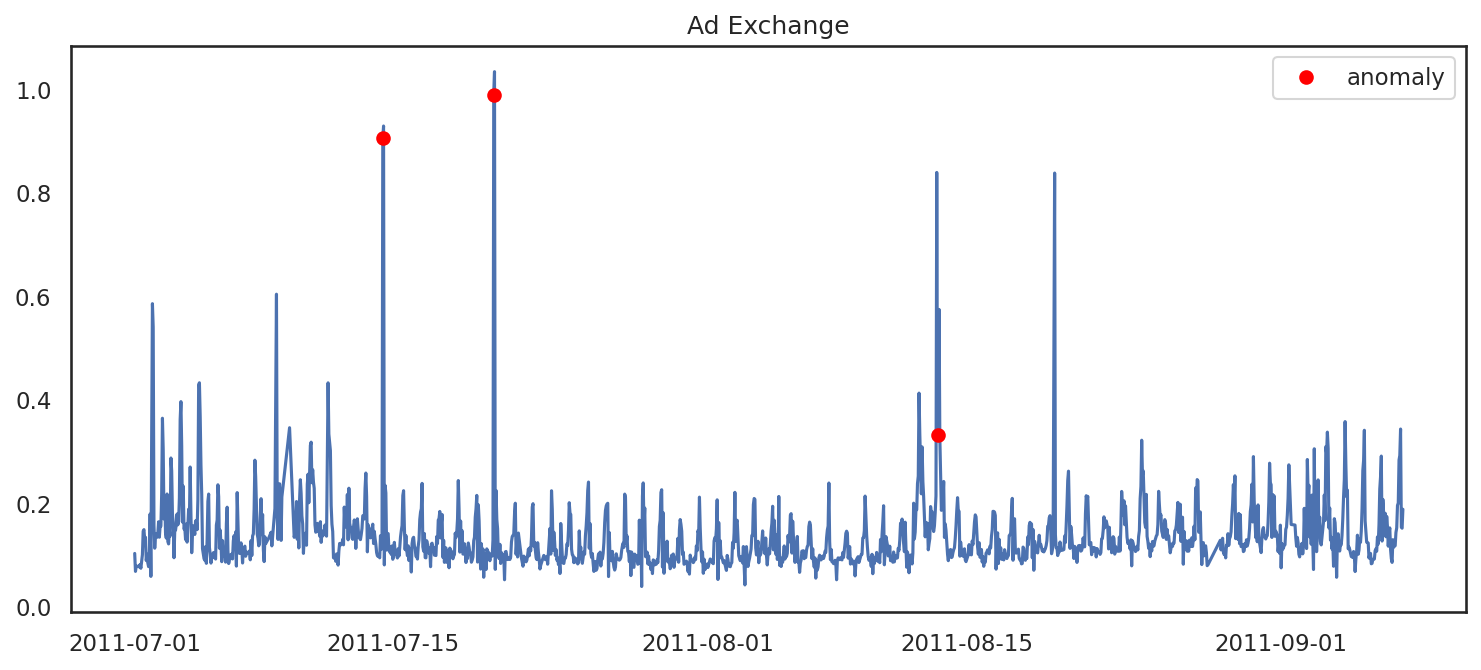

In [107]:
plt.plot(df['value'])
plt.plot(df['anomaly_viz']*df['value'], marker='o', linewidth=0, color='red', label='anomaly')
plt.title('Ad Exchange')
plt.legend()
plt.show()

### Median filtering technique
It can be used to detect outliers and also to denoise some signal (mean can be used also in some cases).
In 2D, median filtering is widely used in image denoising:

<center>
<img src="https://user-images.githubusercontent.com/17388898/84705179-4c95ec80-af5b-11ea-9735-5d1c049903c4.gif" width=250px>
</center>

It can be applied also in one dimension as we'll see in this tutorial:

<center>
<img src="https://user-images.githubusercontent.com/17388898/84705472-b910eb80-af5b-11ea-9792-bad34a187880.png" width=400px>
</center>

**Wikipedia definition:**
The median filter is a nonlinear digital filtering technique, often used to remove noise from an image or signal. Such noise reduction is a typical pre-processing step to improve the results of later processing (for example edge detection on an image). Median filtering is very widely used in digital image processing because, under certain conditions, it preserves edges while removing noise , also having applications in signal processing.

**Algorithm description:**
The main idea of the median filter is to run through the signal entry by entry, replacing each entry with the median of neighboring entries. The pattern of neighbors is called the "window", which slides, entry by entry, over the entire signal. For 1D signals, the most obvious window is just the first few preceding and following entries, whereas for 2D (or higher-dimensional) signals such as images, more complex window patterns are possible (such as "box" or "cross" patterns). Note that if the window has an odd number of entries, then the median is simple to define: it is just the middle value after all the entries in the window are sorted numerically. For an even number of entries, there is more than one possible median.






In [0]:
from dsbox.ml.outliers import MADOutliers

In [0]:
mad_outliers = MADOutliers()

In [0]:
outliers = mad_outliers.fit_predict(df[['value']])

In [0]:
df['outliers'] = outliers
df['outliers'] = df['outliers'].map(lambda x: 1 if x else np.nan)

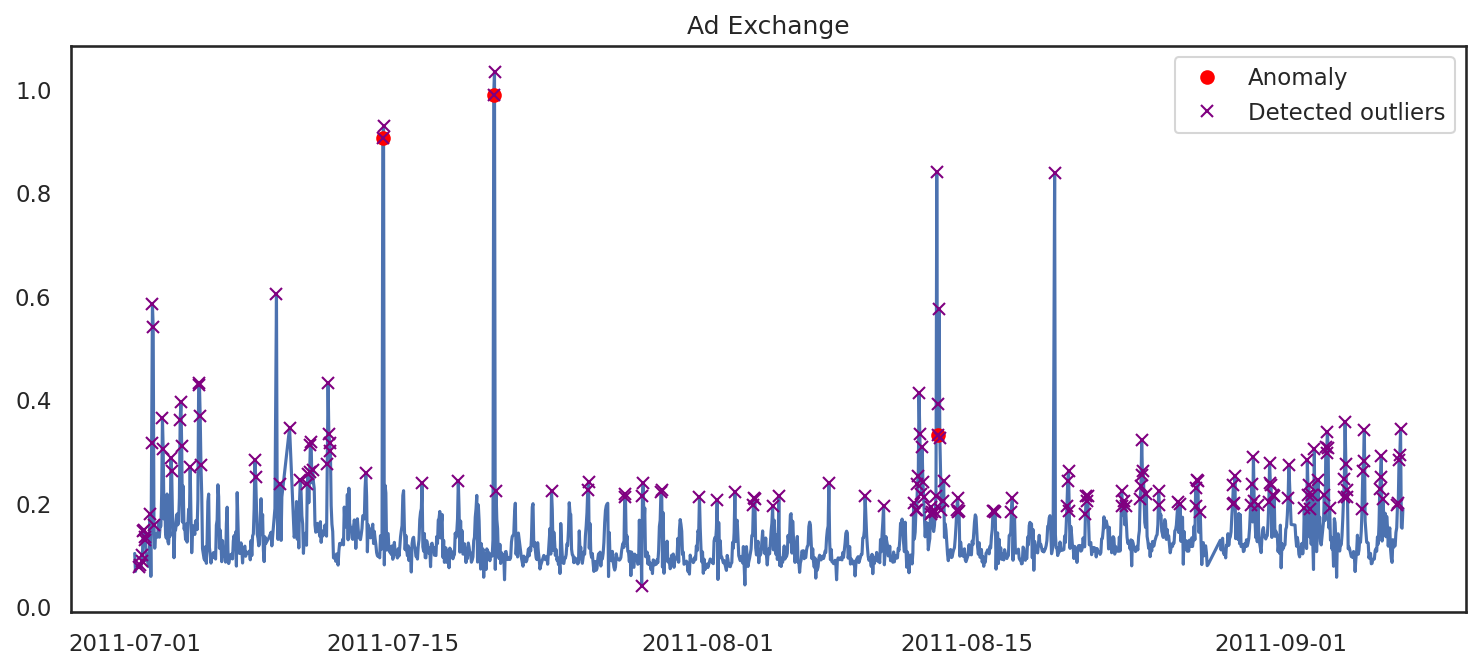

In [117]:
plt.plot(df['value'])
plt.plot(df['anomaly_viz']*df['value'], marker='o', linewidth=0, color='red', label='Anomaly')
plt.plot(df['outliers']*df['value'], marker='x', linewidth=0, color='purple', label='Detected outliers')
plt.title('Ad Exchange')
plt.legend()
plt.show()

In our first experiment, the outliers detection is too sensitive: first, it takes all the data as one window, and second, the `cutoff` parameter is set to 2 by default. It corresponds to the amount of times the residuals relative to the median exceed the ratio to the Median Absolute Deviation.

In a full unsupervised task, the strategy is to produce result, confront them to an expert (in that case, the anomaly labelling), and then trying to do better. We can consider this problem (finding the good window size and cutoff) as an optimization problem that can be handled with techniques like *Grid search* or *Bayesian optimization*. We don't use these techniques here to simplify the explanations.

Let's try with a less sensitive cutoff:

In [0]:
mad_outliers = MADOutliers(cutoff=10)
outliers = mad_outliers.fit_predict(df[['value']])
df['outliers'] = outliers
df['outliers'] = df['outliers'].map(lambda x: 1 if x else np.nan)

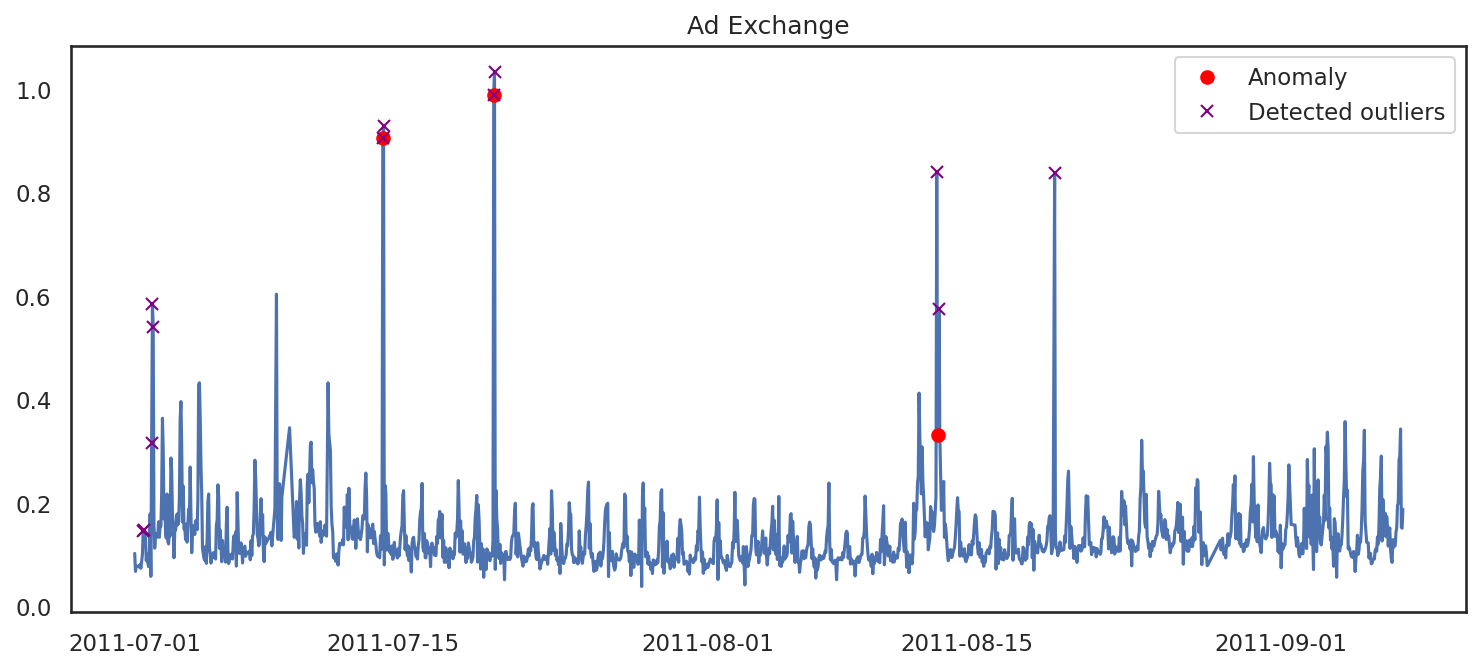

In [119]:
plt.plot(df['value'])
plt.plot(df['anomaly_viz']*df['value'], marker='o', linewidth=0, color='red', label='Anomaly')
plt.plot(df['outliers']*df['value'], marker='x', linewidth=0, color='purple', label='Detected outliers')
plt.title('Ad Exchange')
plt.legend()
plt.show()

Much better ! But let's try again:

In [0]:
mad_outliers = MADOutliers(cutoff=15, window=500)
outliers = mad_outliers.fit_predict(df[['value']])
df['outliers'] = outliers
df['outliers'] = df['outliers'].map(lambda x: 1 if x else np.nan)

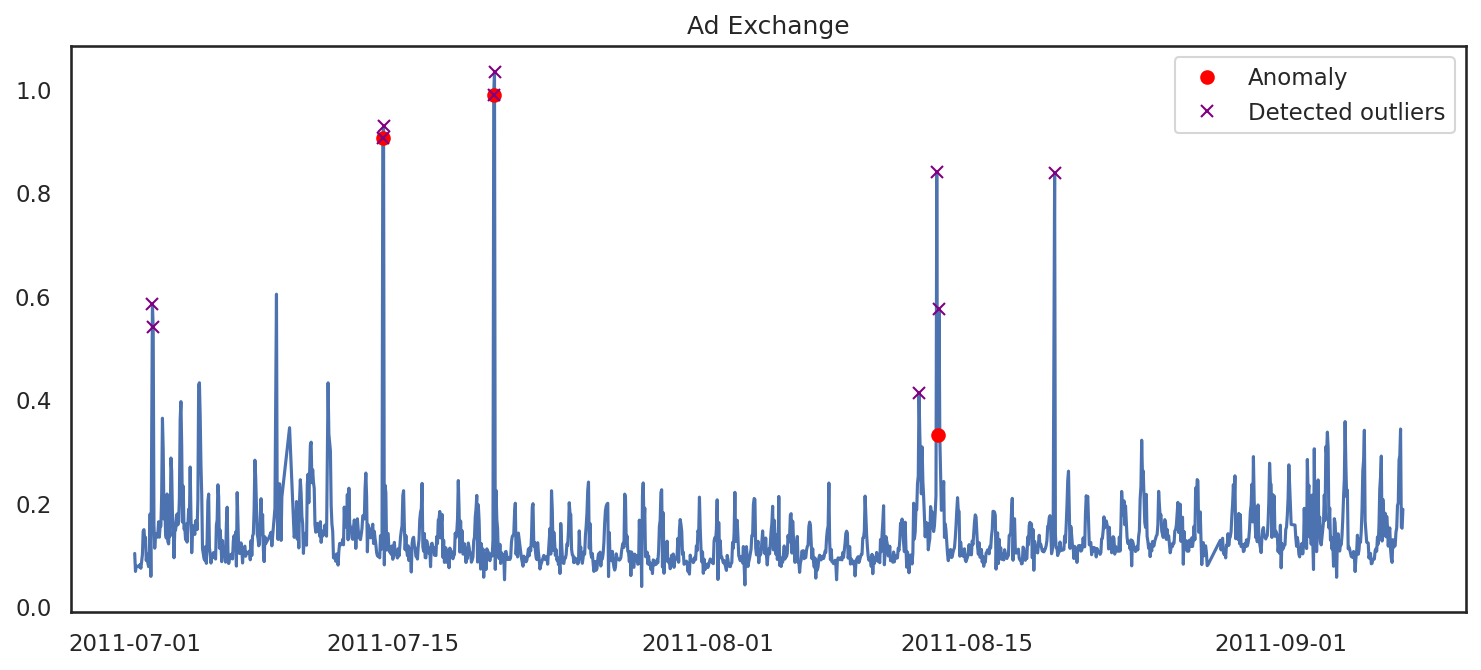

In [205]:
plt.plot(df['value'])
plt.plot(df['anomaly_viz']*df['value'], marker='o', linewidth=0, color='red', label='Anomaly')
plt.plot(df['outliers']*df['value'], marker='x', linewidth=0, color='purple', label='Detected outliers')
plt.title('Ad Exchange')
plt.legend()
plt.show()

It seems that we won't get better, but it's still acceptable. Of course, this example is simple, and finding the best parameters depends on the context.

### FFT filtering technique
The idea is to isolate high frequencies in frequency domain, i.e. fast variations.
Formula of the DFT (Discrete Fourier Transform):
<center>
<img src="https://user-images.githubusercontent.com/17388898/84707406-e8752780-af5e-11ea-89c4-e860031041d7.png" width=300px>
</center>

A little more simple with a FFT example:
<center>
<img src="https://user-images.githubusercontent.com/17388898/84707546-2a9e6900-af5f-11ea-97e2-ce102690e4f4.jpg" width=500px>
</center>

Application to image (low frequencies pass => loosing high contrast difference, i.e. details):
<center>
<img src="https://user-images.githubusercontent.com/17388898/84707625-528dcc80-af5f-11ea-8ddb-e562b7a86415.gif" width=400px>
</center>

**FFT Wikipedia definition:**
A fast Fourier transform (FFT) algorithm computes the discrete Fourier transform (DFT) of a sequence, or its inverse (IFFT). Fourier analysis converts a signal from its original domain (often time or space) to a representation in the frequency domain and vice versa. An FFT rapidly computes such transformations by factorizing the DFT matrix into a product of sparse (mostly zero) factors. As a result, it manages to reduce the complexity of computing the DFT from $O(n^2)$, which arises if one simply applies the definition of DFT, to $O(n.log(n))$, where n is the data size.

In [0]:
from dsbox.ml.outliers import FFTOutliers

In [0]:
fft_outliers = FFTOutliers()

In [0]:
outliers = fft_outliers.fit_predict(df[['value']])

In [0]:
df['outliers'] = outliers.values
df['outliers'] = df['outliers'].map(lambda x: 1 if x else np.nan)

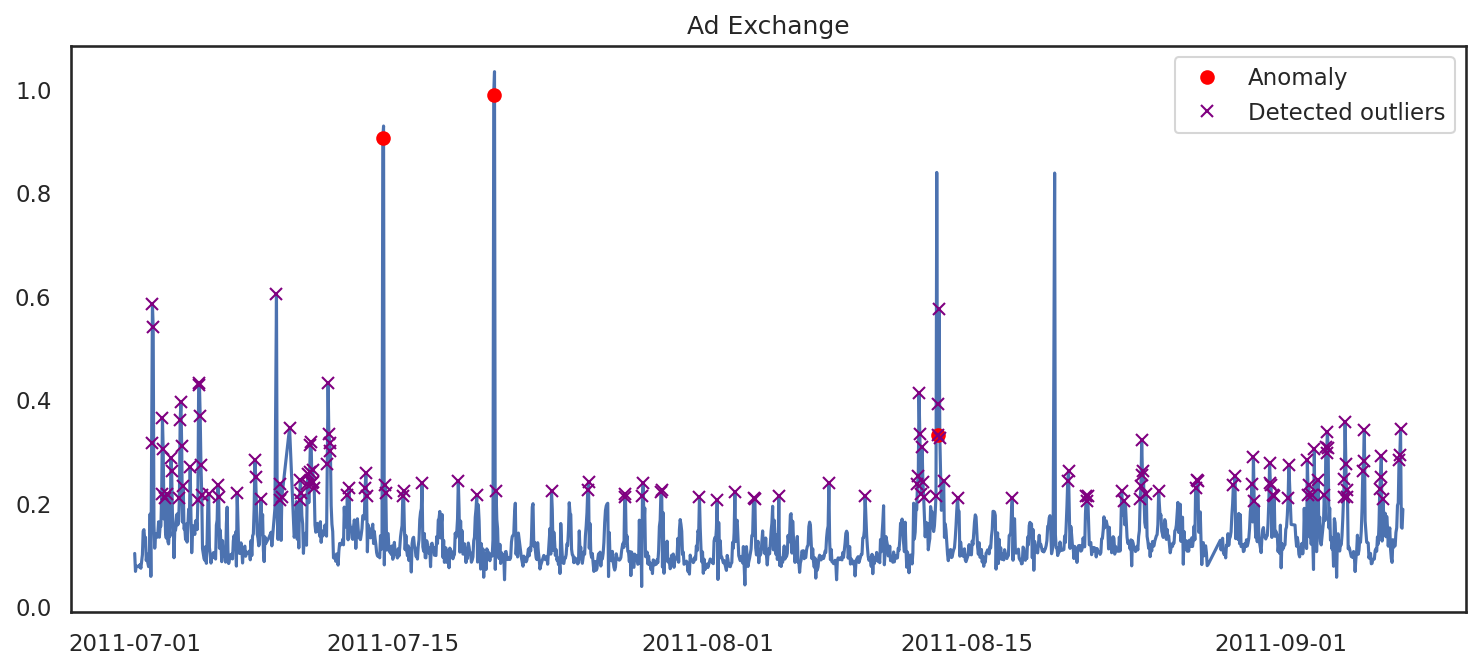

In [313]:
plt.plot(df['value'])
plt.plot(df['anomaly_viz']*df['value'], marker='o', linewidth=0, color='red', label='Anomaly')
plt.plot(df['outliers']*df['value'], marker='x', linewidth=0, color='purple', label='Detected outliers')
plt.title('Ad Exchange')
plt.legend()
plt.show()

Without tuning the parameters, the outliers expulsed by the FFT are too many. Let's try with differents parameters:

In [0]:
fft_outliers = FFTOutliers(freq_cut_index=300, outlier_proportion=0.005)
outliers = fft_outliers.fit_predict(df[['value']])
df['outliers'] = outliers.values
df['outliers'] = df['outliers'].map(lambda x: 1 if x else np.nan)

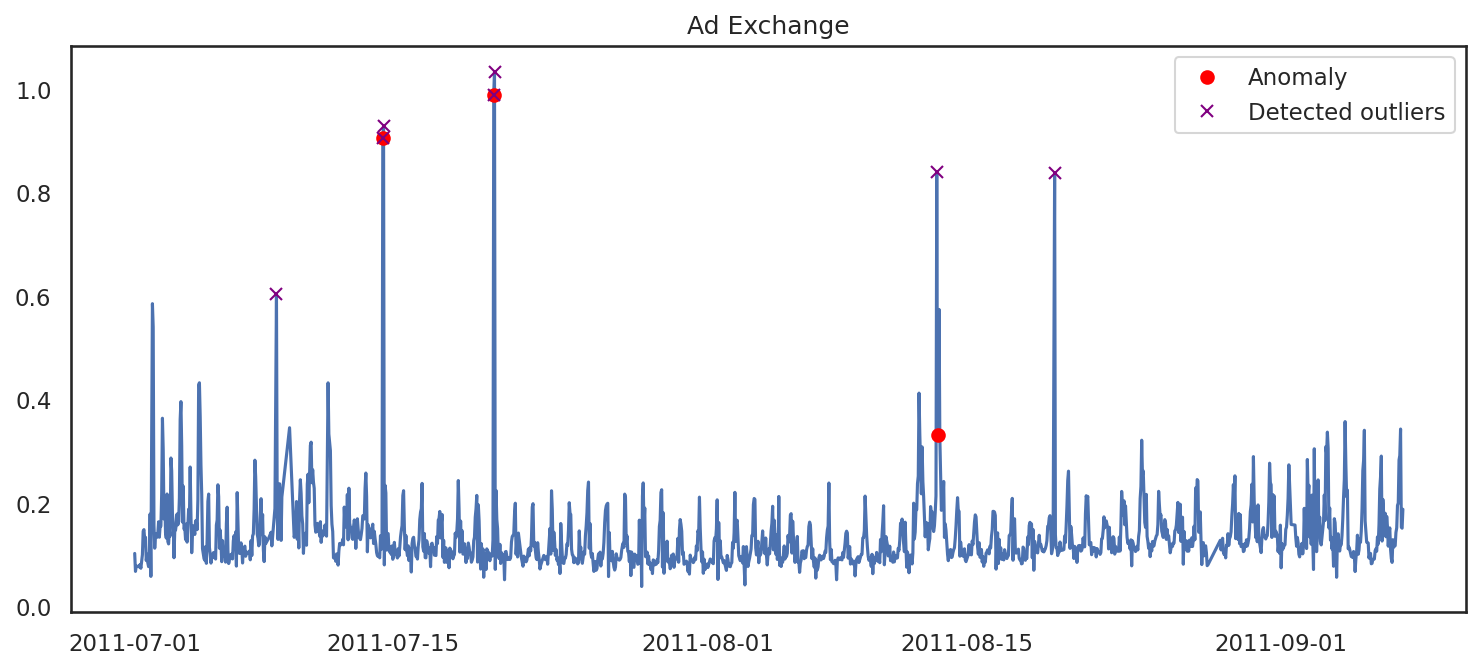

In [343]:
plt.plot(df['value'])
plt.plot(df['anomaly_viz']*df['value'], marker='o', linewidth=0, color='red', label='Anomaly')
plt.plot(df['outliers']*df['value'], marker='x', linewidth=0, color='purple', label='Detected outliers')
plt.title('Ad Exchange')
plt.legend()
plt.show()

Almost there, but it will be difficult to obtain better results.

## Multivariate data: KC2 program defects


### Data import
One of the NASA Metrics Data Program defect data sets. Data from software for science data processing. Data comes from McCabe and Halstead features extractors of source code. These features were defined in the 70s in an attempt to objectively characterize code features that are associated with software quality.

source: https://www.openml.org/d/1063

*Sayyad Shirabad, J. and Menzies, T.J. (2005) The PROMISE Repository of Software Engineering Databases. School of Information Technology and Engineering, University of Ottawa, Canada.*

In [0]:
raw_data = pd.read_csv('https://www.openml.org/data/get_csv/53946/kc2.csv', header=0)

In [345]:
raw_data.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,problems
0,1.1,1.4,1.4,1.4,1.3,1.30,1.30,1.30,1.30,1.30,1.30,1.30,2,2,2,2,1.2,1.2,1.2,1.2,1.4,no
1,1.0,1.0,1.0,1.0,1.0,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1,1,1,1,1.0,1.0,1.0,1.0,1.0,yes
2,415.0,59.0,50.0,51.0,1159.0,8411.31,0.01,103.53,81.24,870848.58,2.80,48380.48,359,35,9,10,47.0,106.0,692.0,467.0,106.0,yes
3,230.0,33.0,10.0,16.0,575.0,3732.82,0.03,39.82,93.74,148644.06,1.24,8258.00,174,15,34,5,23.0,67.0,343.0,232.0,65.0,yes
4,175.0,26.0,12.0,13.0,500.0,3123.96,0.03,29.48,105.96,92103.07,1.04,5116.84,142,7,19,4,18.0,58.0,310.0,190.0,51.0,yes


In [346]:
raw_data.shape

(522, 22)

In [347]:
target_id = 'problems'
target_value = 'yes'

raw_data[target_id].value_counts()

no     415
yes    107
Name: problems, dtype: int64

### Data preparation

In [0]:
X = raw_data.sample(len(raw_data))
X = X.reset_index(drop=True)
X[target_id] = X[target_id].map(lambda x: 1 if x == target_value else 0)
y = X[target_id]
del X[target_id]
y_true = y

As we'll used outlier detection techniques based on clustering, it is preferable to normalize data.

In [0]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X = pd.DataFrame(mms.fit_transform(X),columns=X.columns)

In [351]:
X.head(3)

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,b,t,lOCode,lOComment,lOBlank,lOCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
0,0.004710,0.01676,0.0,0.0,0.008038,0.003813,0.095,0.051483,0.058233,0.000320,0.003549,0.000250,0.004517,0.000000,0.000000,0.0,0.108696,0.027692,0.006483,0.010575,0.016667
1,0.002355,0.00000,0.0,0.0,0.000754,0.000237,0.335,0.014489,0.012842,0.000006,0.000000,0.000004,0.001807,0.000000,0.000000,0.0,0.043478,0.003077,0.000810,0.000661,0.000000
2,0.006279,0.00000,0.0,0.0,0.003014,0.001219,0.125,0.038636,0.024816,0.000077,0.000887,0.000060,0.002710,0.045455,0.016529,0.0,0.108696,0.009231,0.003241,0.002644,0.000000


### Unsupervised outliers detection

In [0]:
from sklearn.metrics import roc_curve, auc

def auc_outliers_estimator(X, y_true, estimator):
    estimator.fit(X)
    y_test = estimator.predict_proba(X)
    fpr, tpr, _ = roc_curve(y_true, y_test)
    return auc(fpr, tpr)

Each estimator has its own approach to detect outliers. See documentation for further explanations.

In [0]:
from dsbox.ml.outliers import CovarianceOutliers
from dsbox.ml.outliers import GMMOutliers
from dsbox.ml.outliers import ClusteringOutliers
from dsbox.ml.outliers import KMeansOneClusterOutliers

In [0]:
score_per_estimator = {}

In [355]:
score = auc_outliers_estimator(X,y_true,CovarianceOutliers())
score_per_estimator['CovarianceOutlier'] = score
print(score)

0.8146042112374732


In [368]:
score = auc_outliers_estimator(X,y_true,GMMOutliers())
score_per_estimator['GMMOutlier'] = score
print(score)

0.780193671883797


In [390]:
from sklearn.cluster import DBSCAN

# can be tricky to parametrize
score = auc_outliers_estimator(X,y_true,
                       ClusteringOutliers(cluster_estimator=DBSCAN(min_samples=15,eps=0.05), strategy='unclustered'))
score_per_estimator['ClusteringOutlier_unclustered'] = score
print(score)

0.7437450737529558


In [408]:
from sklearn.cluster import MiniBatchKMeans

# can be instable due to random_state (try random_state=2... )
score = auc_outliers_estimator(X,y_true,
ClusteringOutliers(cluster_estimator=MiniBatchKMeans(n_clusters=10, random_state=0), 
                                         strategy='size'))
score_per_estimator['ClusteringOutlier_size'] = score
print(score)

0.8282738430356942


In [432]:
score = auc_outliers_estimator(X,y_true,
ClusteringOutliers(cluster_estimator=MiniBatchKMeans(n_clusters=7, random_state=0), 
                                         strategy='frontier'))
score_per_estimator['ClusteringOutlier_frontier'] = score
print(score)

0.711214953271028


In [439]:
from sklearn.cluster import AgglomerativeClustering

score = auc_outliers_estimator(X,y_true,
                       ClusteringOutliers(cluster_estimator=AgglomerativeClustering(n_clusters=40), 
                                         strategy='density'))
score_per_estimator['ClusteringOutlier_density'] = score
print(score)

0.810865893480464


In [442]:
pd.DataFrame({'auc' : score_per_estimator}).sort_values('auc', ascending=False)

,auc
ClusteringOutlier_size,0.828274
CovarianceOutlier,0.814604
ClusteringOutlier_density,0.810866
GMMOutlier,0.780194
ClusteringOutlier_unclustered,0.743745
ClusteringOutlier_frontier,0.711215
